In [1]:
%%bash
#strace -f -tt -T -r -y -o logs/view4.st python src/mmarrays.py 100000
strace -f -tt -T -r -y -o logs/view4.st python src/multi_threaded.py
#strace -f -tt -T -r -y -o logs/view4.st lscpu

In [1]:
from strace_miner.views.v4 import IOMinerV4
from strace_miner.views.v3 import IOLineReaderV3

In [54]:
#st_logs = ['logs/python_a65243794be3_24779.st','logs/python_a65243794be3_24781.st']
st_logs = ['logs/view4.st',]
io_calls = ['read','write']
#line_reader = IOLineReaderV3(['data_rank',],collapse=True)
line_reader = IOLineReaderV3(['/dev/data/',],collapse=False)
#line_reader = IOLineReaderV3(collapse=False)
sta = IOMinerV4(st_logs,io_calls,line_reader)
sta.preprocess()
sta.prepare_summaries_and_event_log()
sta.prepare_dfg()

CSV log path: logs/view4.csv

Overall Summary:

Run time: 0.630s
Total duration of Sys calls: 6.569s
System load: 10.424

IO duration: 0.023s
IO load: 0.35%
Total IO events: 10



/home/vscode/.local/lib/python3.12/site-packages/pm4py/utils.py:538: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


In [55]:
import pm4py
import graphviz

In [56]:
dfg,im,fm = pm4py.discover_dfg(sta.el)

In [57]:
dfg

Counter({('read\n[<4MB]\n/opt/conda', 'read\n[<4KB]\n/opt/conda'): 105,
         ('read\n[<4KB]\n/opt/conda', 'read\n[<4MB]\n/opt/conda'): 103,
         ('read\n[<4KB]\n/opt/conda', 'read\n[<4KB]\n/opt/conda'): 81,
         ('read\n[<4MB]\n/opt/conda', 'read\n[<4MB]\n/opt/conda'): 6,
         ('read\n[<4KB]\n/lib/x86_64-linux-gnu',
          'read\n[<4KB]\n/lib/x86_64-linux-gnu'): 5,
         ('write\n[<4KB]\n/workspaces/hdf5-tutorial.../multi_threaded.npy',
          'write\n[<4KB]\n/workspaces/hdf5-tutorial.../multi_threaded.npy'): 4,
         ('write\n[<4KB]\n/workspaces/hdf5-tutorial.../multi_threaded.npy',
          'write\n[<4MB]\n/workspaces/hdf5-tutorial.../multi_threaded.npy'): 3,
         ('write\n[<4MB]\n/workspaces/hdf5-tutorial.../multi_threaded.npy',
          'write\n[<4KB]\n/workspaces/hdf5-tutorial.../multi_threaded.npy'): 3,
         ('read\n[<4MB]\n/workspaces/hdf5-tutorial',
          'read\n[<4MB]\n/workspaces/hdf5-tutorial'): 2,
         ('read\n[<4KB]\n/opt/conda

In [58]:
im_key = list(im.keys())[0]
fm_key = list(fm.keys())[0]

In [59]:
fm

{'write\n[<4KB]\n/workspaces/hdf5-tutorial.../multi_threaded.npy': 1}

In [135]:
def get_event_attr(event):
    df = sta.activities_summary
    rec = df[df['event']==event]
    count = rec['count'].values[0]
    mp = rec['max_parallel'].values[0]
    io_p = rec['io_percent'].values[0]/100.0
    return "{}/{}/{:.2f}".format(count,mp,io_p)
    

In [136]:
for event in sta.activities:
    print(get_event_attr(event))

6/1/0.02
2/1/0.01
3/1/0.01
2/1/0.00
112/1/0.33
187/1/0.36
4/1/0.01
2/1/0.00
8/1/0.07
4/2/0.19


In [137]:
def prepare_event_attr(sta):
    df = sta.activities_summary
    event_attr = {}
    for event in sta.activities:
        rec = df[df['event']==event]
        count = rec['count'].values[0]
        mp = rec['max_parallel'].values[0]
        io_p = rec['io_percent'].values[0]/100.0
        event_attr[event] = "{}/{}/{:.2f}".format(count,mp,io_p)
    return event_attr

In [145]:
event_attrs = prepare_event_attr(sta)
event_attrs

{'read\n[<4KB]\n/lib/x86_64-linux-gnu': '6/1/0.02',
 'read\n[<4MB]\n/etc/locale.alias': '2/1/0.01',
 'read\n[<4KB]\n/dev/urandom': '3/1/0.01',
 'read\n[<4MB]\n/usr/share': '2/1/0.00',
 'read\n[<4MB]\n/opt/conda': '112/1/0.33',
 'read\n[<4KB]\n/opt/conda': '187/1/0.36',
 'read\n[<4MB]\n/workspaces/hdf5-tutorial': '4/1/0.01',
 'read\n[<4KB]\n/workspaces/hdf5-tutorial': '2/1/0.00',
 'write\n[<4KB]\n/workspaces/hdf5-tutorial.../multi_threaded.npy': '8/1/0.07',
 'write\n[<4MB]\n/workspaces/hdf5-tutorial.../multi_threaded.npy': '4/2/0.19'}

In [148]:

def get_color(trans_count, min_trans_count, max_trans_count):
    trans_base_color = int(255 - 100 * (trans_count - min_trans_count) / (max_trans_count - min_trans_count + 0.00001))
    trans_base_color_hex = str(hex(trans_base_color))[2:].upper()
    return "#" + trans_base_color_hex + trans_base_color_hex + "FF"

In [153]:
def get_event_colors(event_attrs):
    event_colors = {}
    for k,v in event_attrs.items():
        val = float(v.split('/')[-1])
        event_colors[k] = get_color(val,0.0,1.0)
    return event_colors

get_event_colors(event_attrs)
    

{'read\n[<4KB]\n/lib/x86_64-linux-gnu': '#FDFDFF',
 'read\n[<4MB]\n/etc/locale.alias': '#FEFEFF',
 'read\n[<4KB]\n/dev/urandom': '#FEFEFF',
 'read\n[<4MB]\n/usr/share': '#FFFFFF',
 'read\n[<4MB]\n/opt/conda': '#DEDEFF',
 'read\n[<4KB]\n/opt/conda': '#DBDBFF',
 'read\n[<4MB]\n/workspaces/hdf5-tutorial': '#FEFEFF',
 'read\n[<4KB]\n/workspaces/hdf5-tutorial': '#FFFFFF',
 'write\n[<4KB]\n/workspaces/hdf5-tutorial.../multi_threaded.npy': '#F8F8FF',
 'write\n[<4MB]\n/workspaces/hdf5-tutorial.../multi_threaded.npy': '#ECECFF'}

In [177]:
def get_width(val,min_,max_):
    MAX_EDGE_PENWIDTH_GRAPHVIZ = 2.6
    MIN_EDGE_PENWIDTH_GRAPHVIZ = 1.0
    width =  MIN_EDGE_PENWIDTH_GRAPHVIZ + (MAX_EDGE_PENWIDTH_GRAPHVIZ - MIN_EDGE_PENWIDTH_GRAPHVIZ) * (
            val - min_) / (max_ - min_ + 0.00001)
    return str(width)

In [178]:
def get_penwidth_edges(dfg):
    vals = []
    for _,v in dfg.items():
        vals.append(v)
    max_ = max(vals)
    min_ = min(vals)
    
    penwidth_edges = {}
    for k,v in dfg.items():
        width = get_width(v,min_,max_)
        penwidth_edges[k] = width
    return penwidth_edges
get_penwidth_edges(dfg)

{('read\n[<4KB]\n/lib/x86_64-linux-gnu',
  'read\n[<4KB]\n/lib/x86_64-linux-gnu'): '1.0615384556213023',
 ('read\n[<4KB]\n/lib/x86_64-linux-gnu',
  'read\n[<4MB]\n/etc/locale.alias'): '1.0',
 ('read\n[<4MB]\n/etc/locale.alias', 'read\n[<4MB]\n/etc/locale.alias'): '1.0',
 ('read\n[<4MB]\n/etc/locale.alias', 'read\n[<4KB]\n/dev/urandom'): '1.0',
 ('read\n[<4KB]\n/dev/urandom', 'read\n[<4MB]\n/usr/share'): '1.0',
 ('read\n[<4MB]\n/usr/share', 'read\n[<4MB]\n/usr/share'): '1.0',
 ('read\n[<4MB]\n/usr/share', 'read\n[<4MB]\n/opt/conda'): '1.0',
 ('read\n[<4MB]\n/opt/conda', 'read\n[<4KB]\n/opt/conda'): '2.599999846153861',
 ('read\n[<4KB]\n/opt/conda',
  'read\n[<4MB]\n/opt/conda'): '2.5692306183432096',
 ('read\n[<4KB]\n/opt/conda',
  'read\n[<4KB]\n/opt/conda'): '2.2307691124260467',
 ('read\n[<4MB]\n/opt/conda',
  'read\n[<4MB]\n/opt/conda'): '1.0769230695266279',
 ('read\n[<4MB]\n/opt/conda',
  'read\n[<4MB]\n/workspaces/hdf5-tutorial'): '1.0',
 ('read\n[<4MB]\n/workspaces/hdf5-tutorial

In [62]:
from graphviz import Digraph

In [180]:
event_attrs = prepare_event_attr(sta)
event_colors = get_event_colors(event_attrs)
penwidths = get_penwidth_edges(dfg)

graph = Digraph(strict=True, engine='dot',format='png')
graph.attr(rankdir='LR')
start = "<&#9679;>"
end = "<&#9632;>"

graph.node_attr['shape'] = 'box'
# event_node_attr = {
#     'shape':'box',
#     'margin':'0',
#     'fontsize':'10'
# }
#ss = "<<table border=\"0\" cellborder=\"0\" cellspacing=\"0\"><tr><td cellpadding=\"0\" cellspacing=\"0\">{}</td></tr></table>>"



In [187]:
graph.node(start, shape='circle', fontsize="30")
for event in sta.activities:
    attr_str = event_attrs[event]
    label = "{}\n({})".format(event.strip(),attr_str)
    graph.node(event,label=label,style='filled',fillcolor=event_colors[event],fontsize='12')
graph.node(end, shape='doublecircle', fontsize="30")

In [188]:

for event,val in im.items():
    graph.edge(start,event,label=str(val))    

for edge,label in dfg.items():
    graph.edge(edge[0],edge[1],label=str(label),penwidth=penwidths[edge])


for event,val in fm.items():
    graph.edge(event,end,label=str(val))  


In [189]:
def view_in_jupyter(gviz):
    from IPython.display import Image
    image = Image(gviz.render())
    from IPython.display import display
    display(image)

In [190]:
#graph

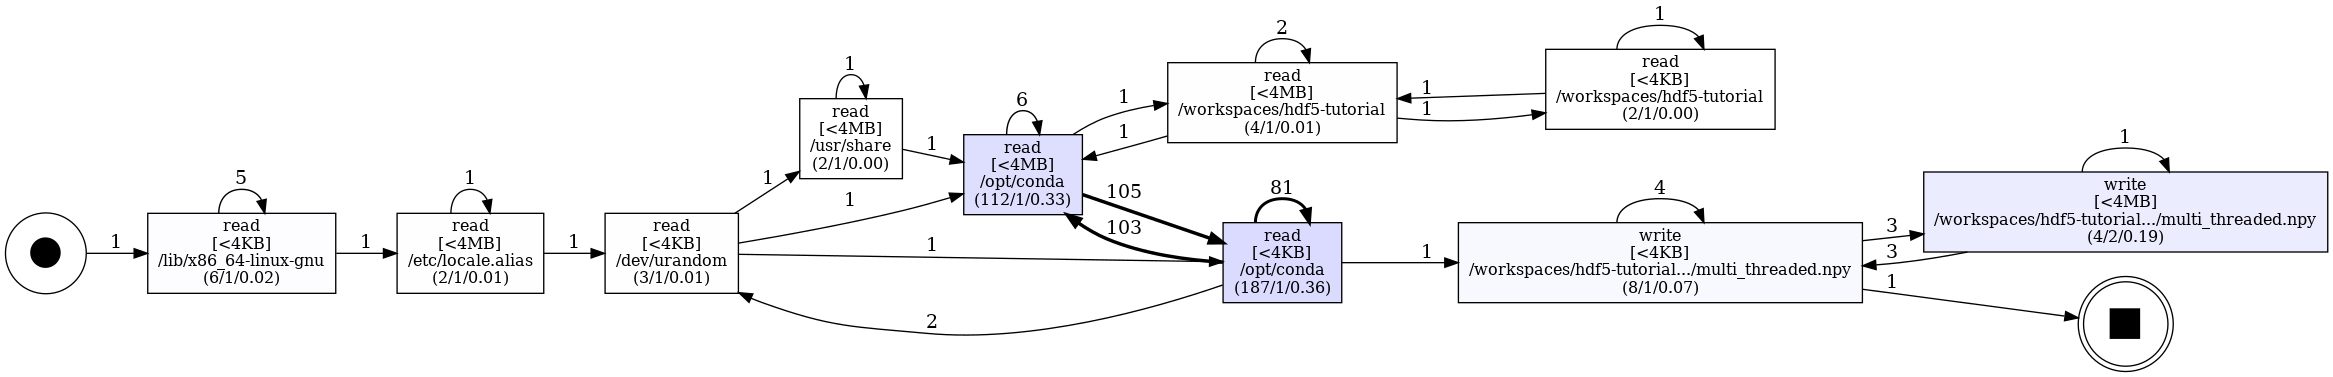

In [191]:
view_in_jupyter(graph)

In [193]:
graph.render('graph/dfg.html')

'graph/dfg.html.png'

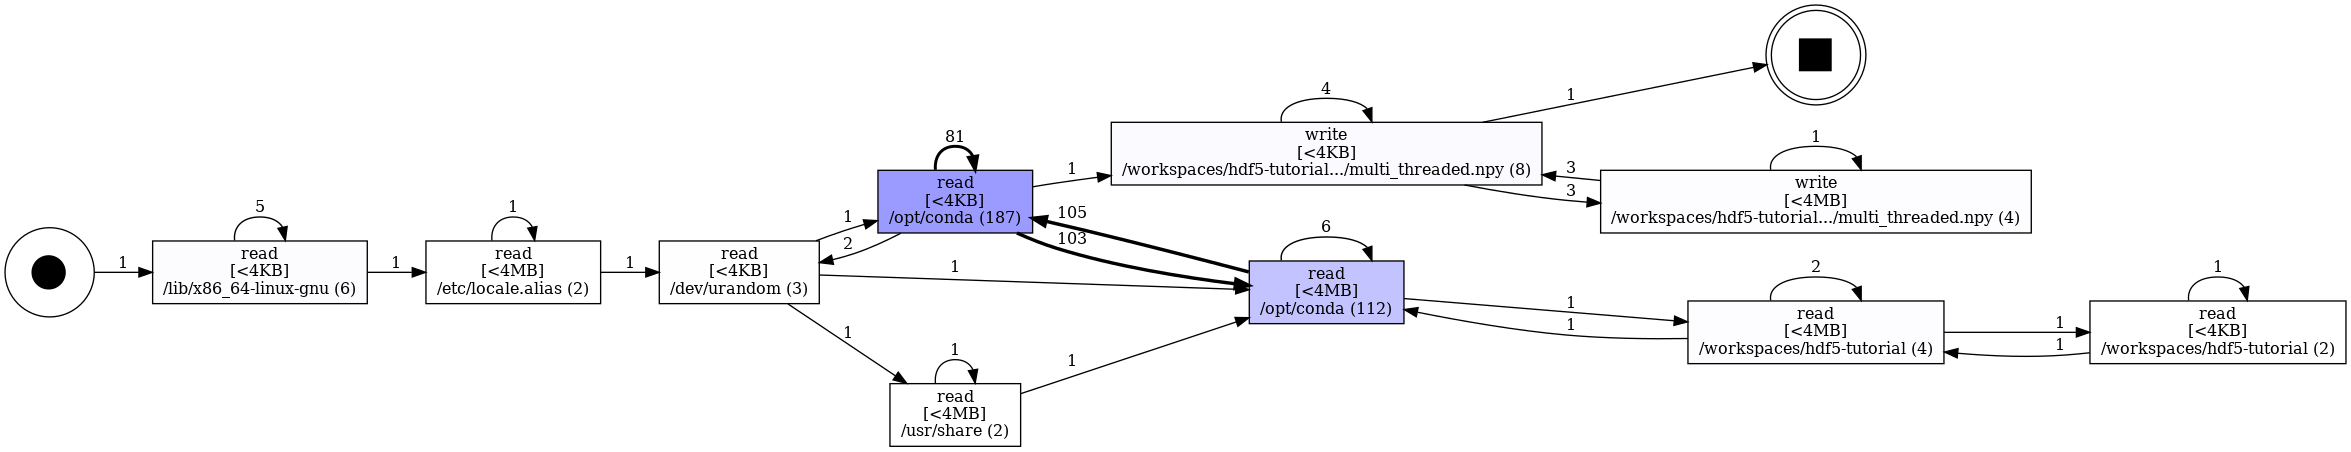

In [124]:
gx = sta.view_dfg()
gx

In [78]:
from pm4py.visualization.dfg import visualizer as dfg_visualizer

In [82]:
def get_dfg_gviz(dfg,im,fm):  
    dfg_parameters = dfg_visualizer.Variants.FREQUENCY.value.Parameters
    parameters = {}
    parameters[dfg_parameters.START_ACTIVITIES] = im
    parameters[dfg_parameters.END_ACTIVITIES] = fm
    
    return dfg_visualizer.apply(dfg, parameters=parameters)

In [83]:
gx = get_dfg_gviz(dfg,im,fm)

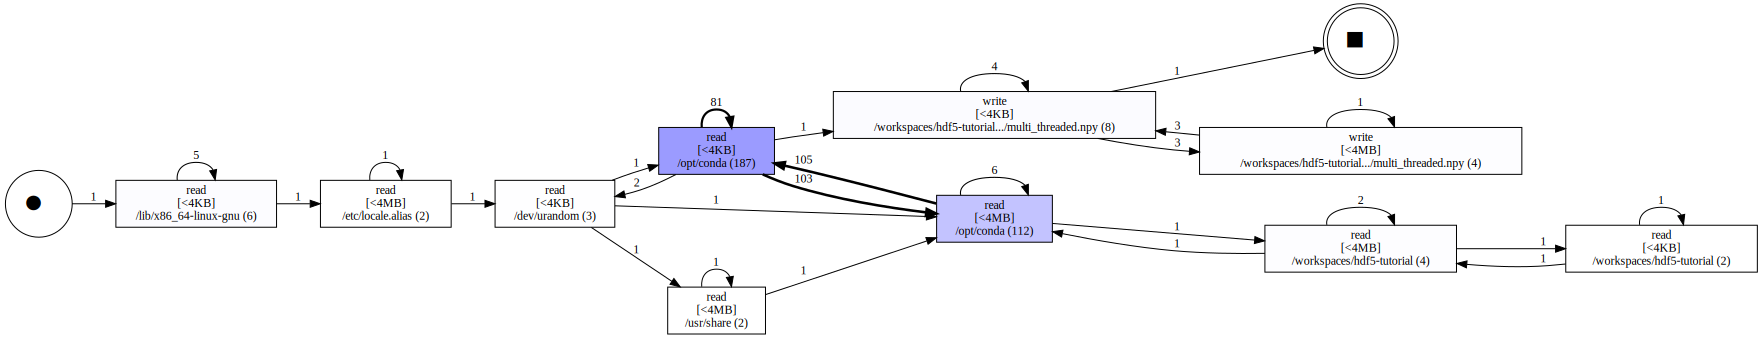

In [93]:
gx

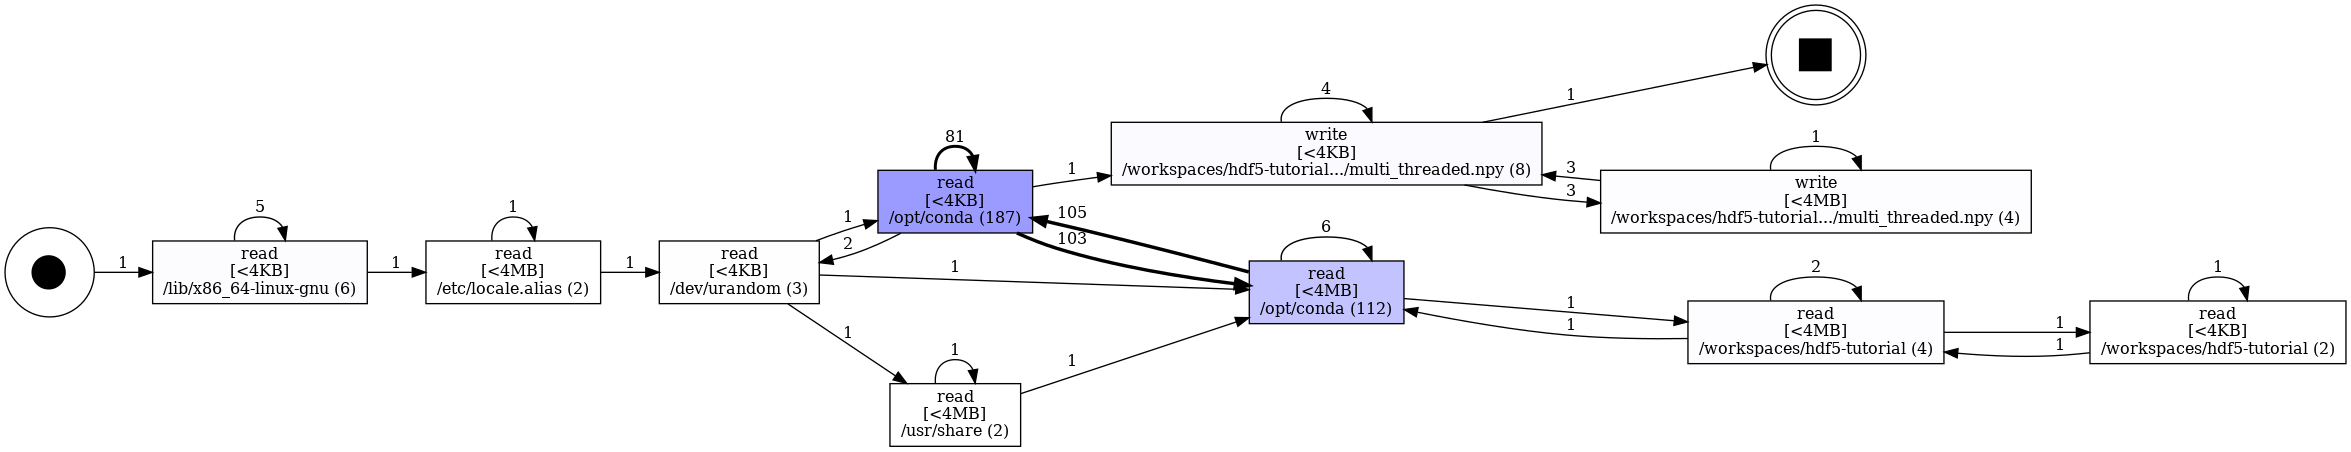

In [94]:
dfg_visualizer.view(gx)